In [1]:
import sys
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from datetime import datetime
sys.path.append("../")
from src.helpers import io
from src.classes.dataset import Dataset
from src.classes.annotation_set import AnnotationSet
from src.helpers.visualisation import (
    barplot_distribution,
    plot_confusion_matrix,
    tabulate_annotation_pair_summary,
    analyze_pair_annotations
)
%load_ext autoreload
%autoreload 2
%matplotlib inline

/Users/fatemehmireshghallah/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Research Questions:
# 1. What is the distribution of sensitive use flags?
# 2. What is the share of conversations flagged for sensitive uses compared to total labeled conversations?
# 3. What is the prevalence of sensitive, sexual, or illegal content in user queries?


In [2]:
# FILL IN:
PATH_TO_DATASET = "../data/static/wildchat4k-raw.json"
DATASET_ID = "wildchat_1m"
PATH_TO_ANNOTATIONS_DIR = "../res/gpto3mini-json-wildchat"

# Load dataset (w/o annotations)
dataset = Dataset.load(PATH_TO_DATASET)

# Load annotations into dataset
for fpath in io.listdir_nohidden(PATH_TO_ANNOTATIONS_DIR):
    annotation_set = AnnotationSet.load_automatic(path=fpath, source="automatic_v0")
    dataset.add_annotations(annotation_set)

prompt-multi_turn_relationship: 0 / 10127 failed due to invalid annotations.
prompt-interaction_features: 0 / 10127 failed due to invalid annotations.
turn-sensitive_use_flags: 0 / 10127 failed due to invalid annotations.
turn-topic: 1 / 10127 failed due to invalid annotations.
response-interaction_features: 0 / 10127 failed due to invalid annotations.
prompt-function_purpose: 6 / 10127 failed due to invalid annotations.
prompt-media_format: 0 / 10127 failed due to invalid annotations.
response-media_format: 0 / 10127 failed due to invalid annotations.
response-answer_form: 0 / 10127 failed due to invalid annotations.


# Research Question 1: What is the distribution of sensitive use flags?

# 

In [ ]:
# Create output directory
outdir = "data/annotation_analysis_v0/sensitive_use_flags"
os.makedirs(outdir, exist_ok=True)

level = "message"
# Get distribution of sensitive use flags
sensitive_flags_distribution = dataset.get_annotation_distribution(
    "turn_sensitive_use_flags",
    level=level,
    annotation_source="automatic_v0",
    annotation_as_list_type=False,
)

# Plot distribution
fig = barplot_distribution(
    {"Sensitive Use Flags": sensitive_flags_distribution}, 
    normalize=True, 
    xlabel="Flag Type", 
    ylabel="Proportion", 
    title=f"Distribution of Sensitive Use Flags at {level} Level",
    output_path=f"{outdir}/dist_flags_barchart_{level}.png", 
    order="descending"
)


# Display the raw counts and percentages
print(f"Distribution of sensitive use flags at {level} Level")
total_flags = sum(sensitive_flags_distribution.values())
for flag, count in sorted(sensitive_flags_distribution.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / total_flags) * 100
    print(f"{flag}: {count} instances ({percentage:.2f}%)")



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Distribution of sensitive use flags at conversation Level


## Research Question 2: What is the share of conversations with sensitive flags?


In [29]:
# Count conversations with at least one sensitive flag
sensitive_conv_count = 0
total_conv_count = len(dataset.data)
conv_with_sensitive_flags = {}

for conv in dataset.data:
    has_sensitive_flag = False
    for msg in conv.conversation:
        if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
            flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
            
            # Handle both list and string cases
            if isinstance(flag_value, list):
                if any(flag != "None" for flag in flag_value):
                    has_sensitive_flag = True
                    break
            elif flag_value and flag_value != "None":
                has_sensitive_flag = True
                break
    
    if has_sensitive_flag:
        sensitive_conv_count += 1
        conv_with_sensitive_flags[conv.conversation_id] = True

# Calculate percentage
percentage_sensitive = (sensitive_conv_count / total_conv_count) * 100

print(f"Total conversations: {total_conv_count}")
print(f"Conversations with sensitive flags: {sensitive_conv_count}")
print(f"Percentage of conversations with sensitive flags: {percentage_sensitive:.2f}%")

# Create pie chart
plt.figure(figsize=(10, 6))
plt.pie([sensitive_conv_count, total_conv_count - sensitive_conv_count], 
        labels=['Sensitive', 'Non-sensitive'],
        autopct='%1.1f%%',
        startangle=90)
plt.axis('equal')
plt.title('Proportion of Conversations with Sensitive Content')
plt.savefig(f"{outdir}/pie_chart.png")
plt.close()

Total conversations: 4000
Conversations with sensitive flags: 593
Percentage of conversations with sensitive flags: 14.82%


## Research Question 3: Prevalence of sensitive content in user vs. assistant messages

In [30]:
# Count sensitive content by role (user vs. assistant)
user_sensitive_count = 0
assistant_sensitive_count = 0
total_user_msgs = 0
total_assistant_msgs = 0

for conv in dataset.data:
    for msg in conv.conversation:
        if msg.role == "user":
            total_user_msgs += 1
            if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
                flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
                if isinstance(flag_value, list):
                    if any(flag != "None" for flag in flag_value):
                        user_sensitive_count += 1
                elif flag_value and flag_value != "None":
                    user_sensitive_count += 1
        elif msg.role == "assistant":
            total_assistant_msgs += 1
            if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
                flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
                if isinstance(flag_value, list):
                    if any(flag != "None" for flag in flag_value):
                        assistant_sensitive_count += 1
                elif flag_value and flag_value != "None":
                    assistant_sensitive_count += 1

# Calculate percentages
user_sensitive_percentage = (user_sensitive_count / total_user_msgs) * 100 if total_user_msgs > 0 else 0
assistant_sensitive_percentage = (assistant_sensitive_count / total_assistant_msgs) * 100 if total_assistant_msgs > 0 else 0

print(f"User messages with sensitive flags: {user_sensitive_count}/{total_user_msgs} ({user_sensitive_percentage:.2f}%)")
print(f"Assistant messages with sensitive flags: {assistant_sensitive_count}/{total_assistant_msgs} ({assistant_sensitive_percentage:.2f}%)")

# Create a bar chart comparing user vs assistant
role_data = {
    "Role": ["User", "Assistant"],
    "Percentage": [user_sensitive_percentage, assistant_sensitive_percentage],
    "Count": [user_sensitive_count, assistant_sensitive_count]
}
role_df = pd.DataFrame(role_data)

plt.figure(figsize=(10, 6))
plt.bar(role_df["Role"], role_df["Percentage"])
plt.xlabel("Role")
plt.ylabel("Percentage with Sensitive Content")
plt.title("Prevalence of Sensitive Content by Role")
for i, v in enumerate(role_df["Percentage"]):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center')
plt.savefig(f"{outdir}/role_comparison.png")
plt.close()

User messages with sensitive flags: 1067/10127 (10.54%)
Assistant messages with sensitive flags: 0/10127 (0.00%)


## Analysis of specific sensitive content types


In [31]:
# Analyze types of sensitive content
sensitive_types = defaultdict(int)
user_sensitive_types = defaultdict(int)
assistant_sensitive_types = defaultdict(int)

for conv in dataset.data:
    for msg in conv.conversation:
        if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
            flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
            
            # Process flags based on whether they're lists or strings
            flags_to_process = []
            if isinstance(flag_value, list):
                flags_to_process = flag_value
            else:
                flags_to_process = [flag_value]
            
            # Count each flag
            for flag in flags_to_process:
                if flag != "None":
                    sensitive_types[flag] += 1
                    
                    # Also track by role
                    if msg.role == "user":
                        user_sensitive_types[flag] += 1
                    elif msg.role == "assistant":
                        assistant_sensitive_types[flag] += 1

# Filter out "None" category if it exists
if "None" in sensitive_types:
    del sensitive_types["None"]

# Plot distribution of sensitive types if any exist
if sensitive_types:
    fig = barplot_distribution(
        {"Sensitive Content Types": dict(sensitive_types)}, 
        normalize=True, 
        xlabel="Content Type", 
        ylabel="Proportion", 
        title="Distribution of Sensitive Content Types",
        output_path=f"{outdir}/content_types.png", 
        order="descending"
    )

    # Print detailed breakdown
    print("Breakdown of sensitive content types:")
    for content_type, count in sorted(sensitive_types.items(), key=lambda x: x[1], reverse=True):
        print(f"{content_type}: {count} instances")
    
    # Compare distribution between user and assistant
    if user_sensitive_types and assistant_sensitive_types:
        # Create a DataFrame for plotting
        types = sorted(set(list(user_sensitive_types.keys()) + list(assistant_sensitive_types.keys())))
        comparison_data = []
        
        for content_type in types:
            user_count = user_sensitive_types.get(content_type, 0)
            assistant_count = assistant_sensitive_types.get(content_type, 0)
            comparison_data.append({
                "Content Type": content_type,
                "User": user_count,
                "Assistant": assistant_count
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        
        # Plot side-by-side bars
        plt.figure(figsize=(14, 8))
        comparison_df.plot(x="Content Type", y=["User", "Assistant"], kind="bar", figsize=(14, 8))
        plt.title("Sensitive Content Types: User vs Assistant")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.savefig(f"{outdir}/user_vs_assistant_types.png")
        plt.close()
else:
    print("No specific sensitive content types found beyond 'None'.")

Breakdown of sensitive content types:
Sexually explicit content (Other): 523 instances
Inciting violence, hateful or other harmful behavior (harassment & bullying): 179 instances
Sexually explicit content (fictitious person): 154 instances
Inciting violence, hateful or other harmful behavior (physical harm): 78 instances
Discriminatory practices (Misrepresentation, stereotyping, or inappropriate reference to sensitive attributes): 62 instances
Criminal planning or other suspected illegal activity not listed elsewhere: 31 instances
Sexually explicit content (Request/discussion of CSAM): 26 instances
Sexually explicit content (real person): 20 instances
Privacy concerns (Possible identifiable information): 14 instances
Weapons & drugs: 11 instances
Cyberattacks (enabling/enacting malware, computer viruses, worms, malicious code, ...): 11 instances
Privacy concerns (Possible sensitive information): 10 instances
Generating defamatory content: 6 instances
Inciting violence, hateful or other

/Users/fatemehmireshghallah/Downloads/naturalistic-ai/notebooks/../src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')


## Temporal analysis of sensitive content


In [32]:
# Analyze temporal distribution if time data is available
if hasattr(dataset.data[0], 'time') and dataset.data[0].time:
    # Convert time strings to datetime objects
    temporal_data = []
    for conv in dataset.data:
        if conv.time:
            try:
                time_obj = datetime.fromisoformat(conv.time.replace('Z', '+00:00'))
                has_sensitive = False
                
                for msg in conv.conversation:
                    if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
                        flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
                        if isinstance(flag_value, list):
                            if any(flag != "None" for flag in flag_value):
                                has_sensitive = True
                                break
                        elif flag_value and flag_value != "None":
                            has_sensitive = True
                            break
                
                temporal_data.append((time_obj, has_sensitive))
            except ValueError:
                print(f"Warning: Could not parse time format for conversation {conv.conversation_id}")
    
    # Sort by time
    temporal_data.sort(key=lambda x: x[0])
    
    # Group by month
    monthly_data = defaultdict(lambda: {"sensitive": 0, "total": 0})
    for time_obj, has_sensitive in temporal_data:
        month_key = time_obj.strftime("%Y-%m")
        monthly_data[month_key]["total"] += 1
        if has_sensitive:
            monthly_data[month_key]["sensitive"] += 1
    
    # Calculate monthly percentages
    months = []
    percentages = []
    
    for month, counts in sorted(monthly_data.items()):
        months.append(month)
        percentage = (counts["sensitive"] / counts["total"]) * 100 if counts["total"] > 0 else 0
        percentages.append(percentage)
    
    # Plot monthly trend
    plt.figure(figsize=(12, 6))
    plt.plot(months, percentages, marker='o')
    plt.xlabel('Month')
    plt.ylabel('Percentage of Conversations with Sensitive Content')
    plt.title('Monthly Trend of Sensitive Content')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{outdir}/monthly_trend.png")
    plt.close()

## Geographic analysis of sensitive content


In [33]:
# Analyze geographical distribution if geography data is available
if hasattr(dataset.data[0], 'geography') and dataset.data[0].geography:
    # Group by geography
    geo_data = defaultdict(lambda: {"sensitive": 0, "total": 0})
    
    for conv in dataset.data:
        if conv.geography:
            # Extract country from geography (format might be "Country; Region")
            country = conv.geography.split(';')[0].strip() if ';' in conv.geography else conv.geography
            
            # Check if conversation has sensitive content
            has_sensitive = False
            for msg in conv.conversation:
                if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
                    flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
                    if isinstance(flag_value, list):
                        if any(flag != "None" for flag in flag_value):
                            has_sensitive = True
                            break
                    elif flag_value and flag_value != "None":
                        has_sensitive = True
                        break
            
            # Update counts
            geo_data[country]["total"] += 1
            if has_sensitive:
                geo_data[country]["sensitive"] += 1
    
    # Calculate percentages and prepare data for plotting
    geo_percentages = {}
    
    for country, counts in geo_data.items():
        if counts["total"] >= 10:  # Only include countries with sufficient data
            percentage = (counts["sensitive"] / counts["total"]) * 100
            geo_percentages[country] = percentage
    
    # Sort countries by percentage
    sorted_countries = sorted(geo_percentages.items(), key=lambda x: x[1], reverse=True)
    
    # Plot geographical distribution
    if sorted_countries:
        countries, percentages = zip(*sorted_countries[:15])  # Top 15 countries
        
        plt.figure(figsize=(14, 8))
        plt.bar(countries, percentages)
        plt.xlabel('Country')
        plt.ylabel('Percentage of Conversations with Sensitive Content')
        plt.title('Sensitive Content by Country (Top 15)')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig(f"{outdir}/geo_distribution.png")
        plt.close()
        
        # Print detailed breakdown
        print("\nBreakdown of sensitive content by country:")
        for country, percentage in sorted_countries:
            total = geo_data[country]["total"]
            sensitive = geo_data[country]["sensitive"]
            print(f"{country}: {sensitive}/{total} ({percentage:.2f}%)")


Breakdown of sensitive content by country:
United Arab Emirates: 7/14 (50.00%)
Jamaica: 5/13 (38.46%)
Estonia: 8/21 (38.10%)
Italy: 19/59 (32.20%)
Türkiye: 14/49 (28.57%)
United Kingdom: 36/155 (23.23%)
Spain: 4/18 (22.22%)
Russia: 131/610 (21.48%)
Germany: 29/138 (21.01%)
United States: 168/872 (19.27%)
Romania: 6/32 (18.75%)
The Netherlands: 7/38 (18.42%)
Australia: 9/51 (17.65%)
Belarus: 4/23 (17.39%)
Ukraine: 3/18 (16.67%)
Mexico: 3/18 (16.67%)
Malaysia: 2/12 (16.67%)
Canada: 15/91 (16.48%)
France: 20/124 (16.13%)
Peru: 2/14 (14.29%)
Brazil: 8/58 (13.79%)
Kazakhstan: 2/15 (13.33%)
Saudi Arabia: 2/17 (11.76%)
Indonesia: 2/18 (11.11%)
Poland: 3/27 (11.11%)
South Korea: 2/19 (10.53%)
Hungary: 1/11 (9.09%)
Singapore: 4/47 (8.51%)
Japan: 7/87 (8.05%)
Taiwan: 4/51 (7.84%)
Argentina: 1/13 (7.69%)
India: 5/70 (7.14%)
Vietnam: 2/32 (6.25%)
Philippines: 3/57 (5.26%)
Morocco: 1/21 (4.76%)
New Zealand: 1/25 (4.00%)
Iran: 1/26 (3.85%)
China: 15/404 (3.71%)
Hong Kong: 7/207 (3.38%)
Egypt: 2/61 

## Model comparison analysis


In [34]:
# Analyze by model if model data is available
if hasattr(dataset.data[0], 'model') and dataset.data[0].model:
    # Group by model
    model_data = defaultdict(lambda: {"sensitive": 0, "total": 0})
    
    for conv in dataset.data:
        if conv.model:
            # Check if conversation has sensitive content
            has_sensitive = False
            for msg in conv.conversation:
                if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
                    flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
                    if isinstance(flag_value, list):
                        if any(flag != "None" for flag in flag_value):
                            has_sensitive = True
                            break
                    elif flag_value and flag_value != "None":
                        has_sensitive = True
                        break
            
            # Update counts
            model_data[conv.model]["total"] += 1
            if has_sensitive:
                model_data[conv.model]["sensitive"] += 1
    
    # Calculate percentages and prepare data for plotting
    model_percentages = {}
    
    for model, counts in model_data.items():
        if counts["total"] >= 5:  # Only include models with sufficient data
            percentage = (counts["sensitive"] / counts["total"]) * 100
            model_percentages[model] = percentage
    
    # Sort models by percentage
    sorted_models = sorted(model_percentages.items(), key=lambda x: x[1], reverse=True)
    
    # Plot model distribution
    if sorted_models:
        models, percentages = zip(*sorted_models)
        
        plt.figure(figsize=(12, 6))
        plt.bar(models, percentages)
        plt.xlabel('Model')
        plt.ylabel('Percentage of Conversations with Sensitive Content')
        plt.title('Sensitive Content by Model')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig(f"{outdir}/model_distribution.png")
        plt.close()
        
        # Print detailed breakdown
        print("\nBreakdown of sensitive content by model:")
        for model, percentage in sorted_models:
            total = model_data[model]["total"]
            sensitive = model_data[model]["sensitive"]
            print(f"{model}: {sensitive}/{total} ({percentage:.2f}%)")


Breakdown of sensitive content by model:
gpt-4-0314: 30/190 (15.79%)
gpt-4-1106-preview: 98/635 (15.43%)
gpt-3.5-turbo-0613: 280/1864 (15.02%)
gpt-3.5-turbo-0301: 103/703 (14.65%)
gpt-4-0125-preview: 43/310 (13.87%)
gpt-3.5-turbo-0125: 39/298 (13.09%)


In [35]:
# Calculate some final statistics
total_messages = sum(1 for conv in dataset.data for _ in conv.conversation)
sensitive_messages = sum(
    1 for conv in dataset.data 
    for msg in conv.conversation 
    if "automatic_v0-turn_sensitive_use_flags" in msg.metadata and (
        (isinstance(msg.metadata["automatic_v0-turn_sensitive_use_flags"].value, list) and 
         any(flag != "None" for flag in msg.metadata["automatic_v0-turn_sensitive_use_flags"].value)) or
        (not isinstance(msg.metadata["automatic_v0-turn_sensitive_use_flags"].value, list) and 
         msg.metadata["automatic_v0-turn_sensitive_use_flags"].value != "None")
    )
)

print("\nSummary Statistics:")
print(f"Total conversations: {total_conv_count}")
print(f"Total messages: {total_messages}")
print(f"Conversations with sensitive content: {sensitive_conv_count} ({percentage_sensitive:.2f}%)")
print(f"Messages with sensitive content: {sensitive_messages} ({(sensitive_messages/total_messages)*100:.2f}%)")
print(f"User messages with sensitive content: {user_sensitive_count}/{total_user_msgs} ({user_sensitive_percentage:.2f}%)")
print(f"Assistant messages with sensitive content: {assistant_sensitive_count}/{total_assistant_msgs} ({assistant_sensitive_percentage:.2f}%)")

if sensitive_types:
    print("\nTop sensitive content types:")
    for content_type, count in sorted(sensitive_types.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"- {content_type}: {count} instances")


Summary Statistics:
Total conversations: 4000
Total messages: 20254
Conversations with sensitive content: 593 (14.82%)
Messages with sensitive content: 1067 (5.27%)
User messages with sensitive content: 1067/10127 (10.54%)
Assistant messages with sensitive content: 0/10127 (0.00%)

Top sensitive content types:
- Sexually explicit content (Other): 523 instances
- Inciting violence, hateful or other harmful behavior (harassment & bullying): 179 instances
- Sexually explicit content (fictitious person): 154 instances
- Inciting violence, hateful or other harmful behavior (physical harm): 78 instances
- Discriminatory practices (Misrepresentation, stereotyping, or inappropriate reference to sensitive attributes): 62 instances


# Round 2 of Analysis

# RQ 1: 1. Pie Chart of Sensitive Flag Distribution (Excluding 'None')


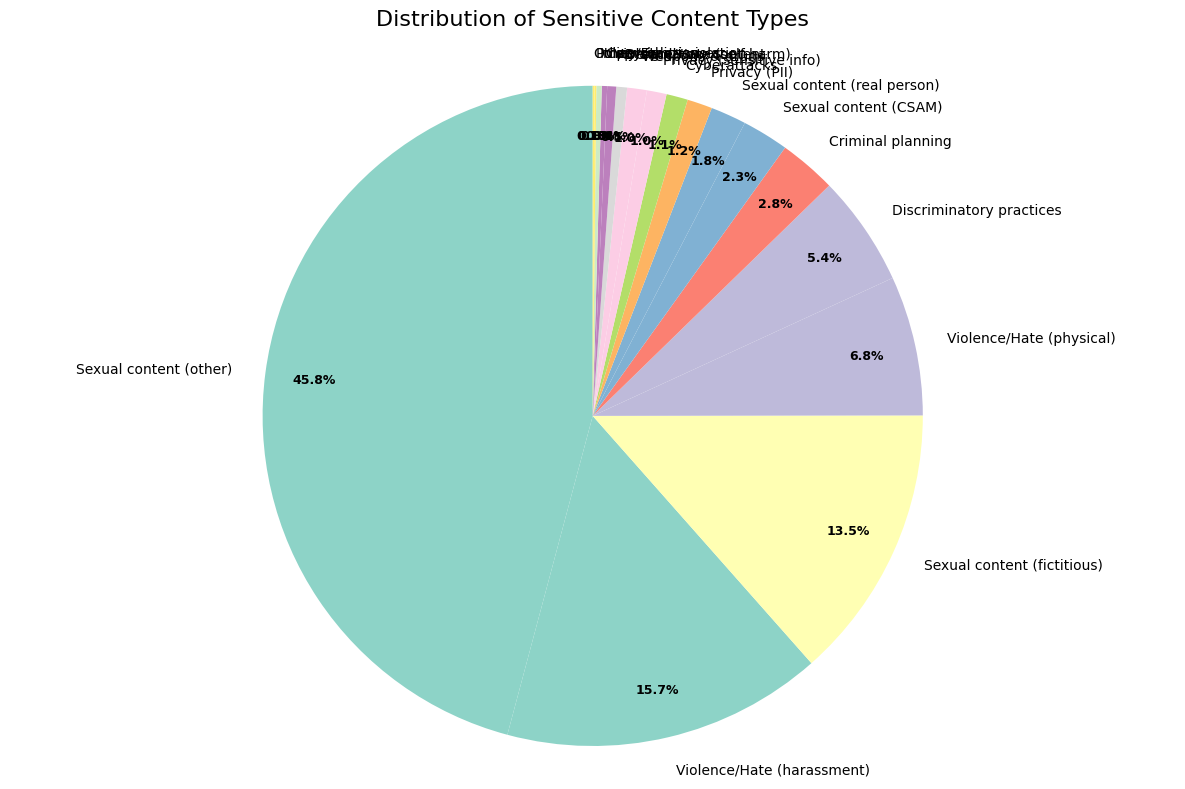

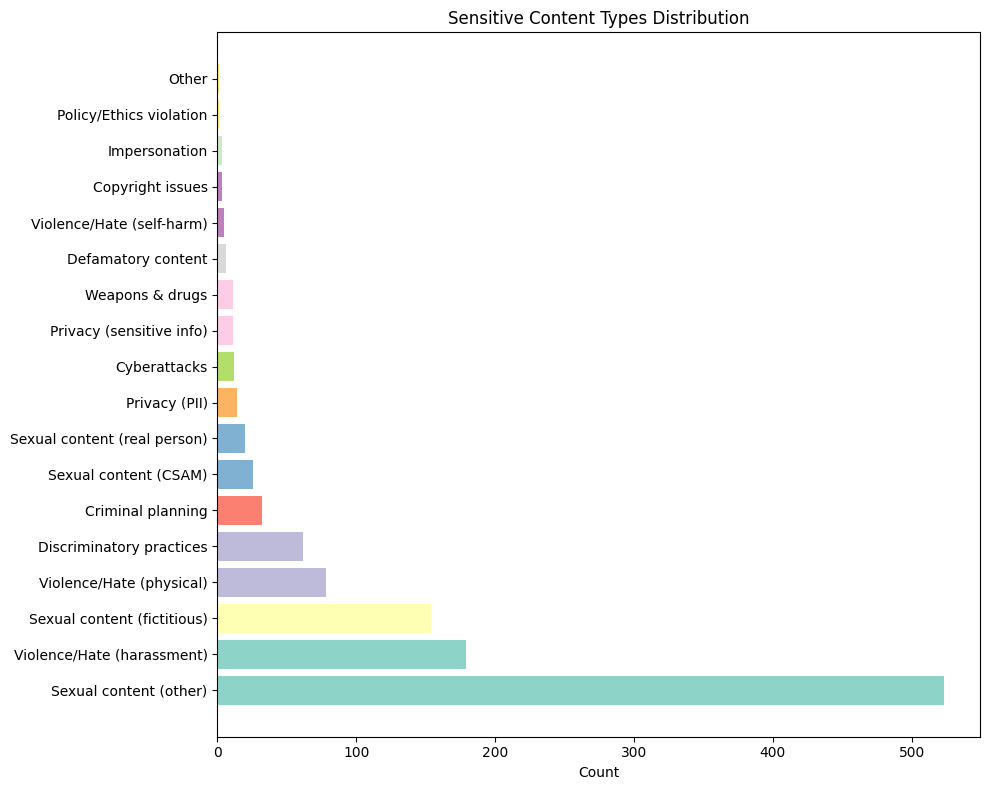

Consolidated Sensitive Flag Distribution:
Sexual content (other): 523
Violence/Hate (harassment): 179
Sexual content (fictitious): 154
Violence/Hate (physical): 78
Discriminatory practices: 62
Criminal planning: 32
Sexual content (CSAM): 26
Sexual content (real person): 20
Privacy (PII): 14
Cyberattacks: 12
Privacy (sensitive info): 11
Weapons & drugs: 11
Defamatory content: 6
Violence/Hate (self-harm): 5
Copyright issues: 3
Impersonation: 3
Policy/Ethics violation: 1
Other: 1


In [26]:
# First, let's consolidate similar flag types
def consolidate_flag_types(flag):
    """Consolidate similar flag types into cleaner categories"""
    flag_mapping = {
        'Criminal planning or other suspected illegal activity not listed elsewhere': 'Criminal planning',
        'Criminal planning or other suspected illegal activity not listed': 'Criminal planning',
        'Cyberattacks (enabling/enacting malware, computer viruses, worms, malicious code, ...)': 'Cyberattacks',
        'Cyberattacks': 'Cyberattacks',
        'Discriminatory practices (Misrepresentation, stereotyping, or inappropriate reference to sensitive attributes)': 'Discriminatory practices',
        'Generating defamatory content': 'Defamatory content',
        'Impersonation attempts': 'Impersonation',
        'Inciting violence, hateful or other harmful behavior (harassment & bullying)': 'Violence/Hate (harassment)',
        'Inciting violence, hateful or other harmful behavior (physical harm)': 'Violence/Hate (physical)',
        'Inciting violence, hateful or other harmful behavior (self-harm)': 'Violence/Hate (self-harm)',
        'Sexually explicit content (Other)': 'Sexual content (other)',
        'Sexually explicit content (fictitious person)': 'Sexual content (fictitious)',
        'Sexually explicit content (real person)': 'Sexual content (real person)',
        'Sexually explicit content (Request/discussion of CSAM)': 'Sexual content (CSAM)',
        'Privacy concerns (Possible identifiable information)': 'Privacy (PII)',
        'Privacy concerns (Possible sensitive information)': 'Privacy (sensitive info)',
        'Privacy concerns (Possible sensitive information) (e.g., API keys, passwords, other confidential information)': 'Privacy (sensitive info)',
        'Weapons & drugs': 'Weapons & drugs',
        'Possible presence of copyrighted, unreferenced material': 'Copyright issues',
        'Potential violation of external policy / ethics': 'Policy/Ethics violation',
        'Other': 'Other',
        'None': 'None'
    }
    return flag_mapping.get(flag, flag[:50] + '...' if len(flag) > 50 else flag)

# Get distribution of sensitive flags from raw data
consolidated_distribution = {}
for conv in dataset.data:
    for msg in conv.conversation:
        if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
            flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
            if isinstance(flag_value, list):
                for flag in flag_value:
                    if flag != "None":
                        consolidated_flag = consolidate_flag_types(flag)
                        consolidated_distribution[consolidated_flag] = consolidated_distribution.get(consolidated_flag, 0) + 1
            elif flag_value and flag_value != "None":
                consolidated_flag = consolidate_flag_types(flag_value)
                consolidated_distribution[consolidated_flag] = consolidated_distribution.get(consolidated_flag, 0) + 1

# Sort by count for better visualization
sorted_flags = sorted(consolidated_distribution.items(), key=lambda x: x[1], reverse=True)

if sorted_flags:
    # Create pie chart
    labels, counts = zip(*sorted_flags)
    
    plt.figure(figsize=(12, 8))
    colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
    
    # Create pie chart with better formatting
    wedges, texts, autotexts = plt.pie(counts, labels=labels, autopct='%1.1f%%', 
                                        startangle=90, colors=colors, pctdistance=0.85)
    
    # Improve text readability
    for text in texts:
        text.set_fontsize(10)
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(9)
        autotext.set_weight('bold')
    
    plt.title('Distribution of Sensitive Content Types', fontsize=16, pad=20)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig(f"{outdir}/sensitive_flags_pie_chart_fixed.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Also create a horizontal bar chart for better label visibility
    plt.figure(figsize=(10, 8))
    y_pos = np.arange(len(labels))
    plt.barh(y_pos, counts, color=colors)
    plt.yticks(y_pos, labels)
    plt.xlabel('Count')
    plt.title('Sensitive Content Types Distribution')
    plt.tight_layout()
    plt.savefig(f"{outdir}/sensitive_flags_bar_horizontal.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("Consolidated Sensitive Flag Distribution:")
    for label, count in sorted_flags:
        print(f"{label}: {count}")

# RQ 2 2. Pie  Chart of Country Contribution to Sensitive Flags


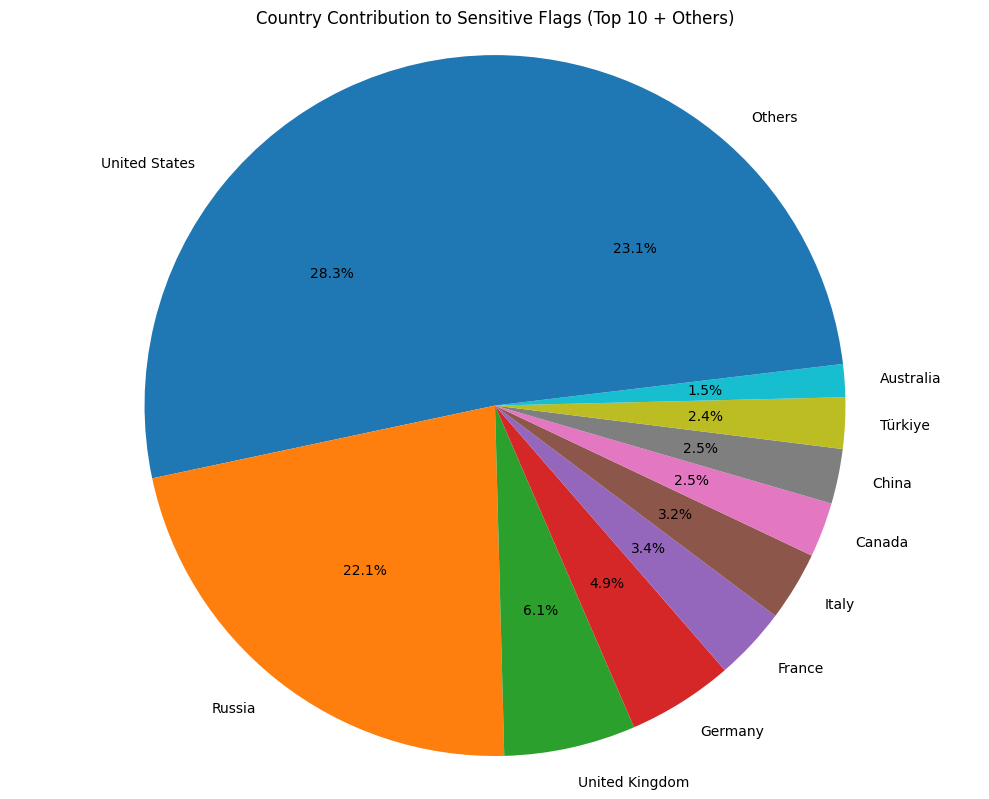

In [14]:
# Calculate country contribution to sensitive flags
country_sensitive_counts = defaultdict(int)

for conv in dataset.data:
    if conv.geography:
        country = conv.geography.split(';')[0].strip() if ';' in conv.geography else conv.geography
        
        # Check if conversation has sensitive content
        for msg in conv.conversation:
            if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
                flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
                if isinstance(flag_value, list):
                    if any(flag != "None" for flag in flag_value):
                        country_sensitive_counts[country] += 1
                        break
                elif flag_value and flag_value != "None":
                    country_sensitive_counts[country] += 1
                    break

# Sort countries by contribution and take top 10
sorted_countries = sorted(country_sensitive_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_countries, top_counts = zip(*sorted_countries)

# Add "Others" category
others_count = sum(count for country, count in country_sensitive_counts.items() 
                  if country not in top_countries)
if others_count > 0:
    top_countries = list(top_countries) + ["Others"]
    top_counts = list(top_counts) + [others_count]

# Create pie chart
plt.figure(figsize=(10, 8))
plt.pie(top_counts, labels=top_countries, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Country Contribution to Sensitive Flags (Top 10 + Others)')
plt.tight_layout()
plt.savefig(f"{outdir}/country_contribution_pie_chart.png")
plt.show()

# RQ 3 Normalized Bar Chart by Country's Total Queries

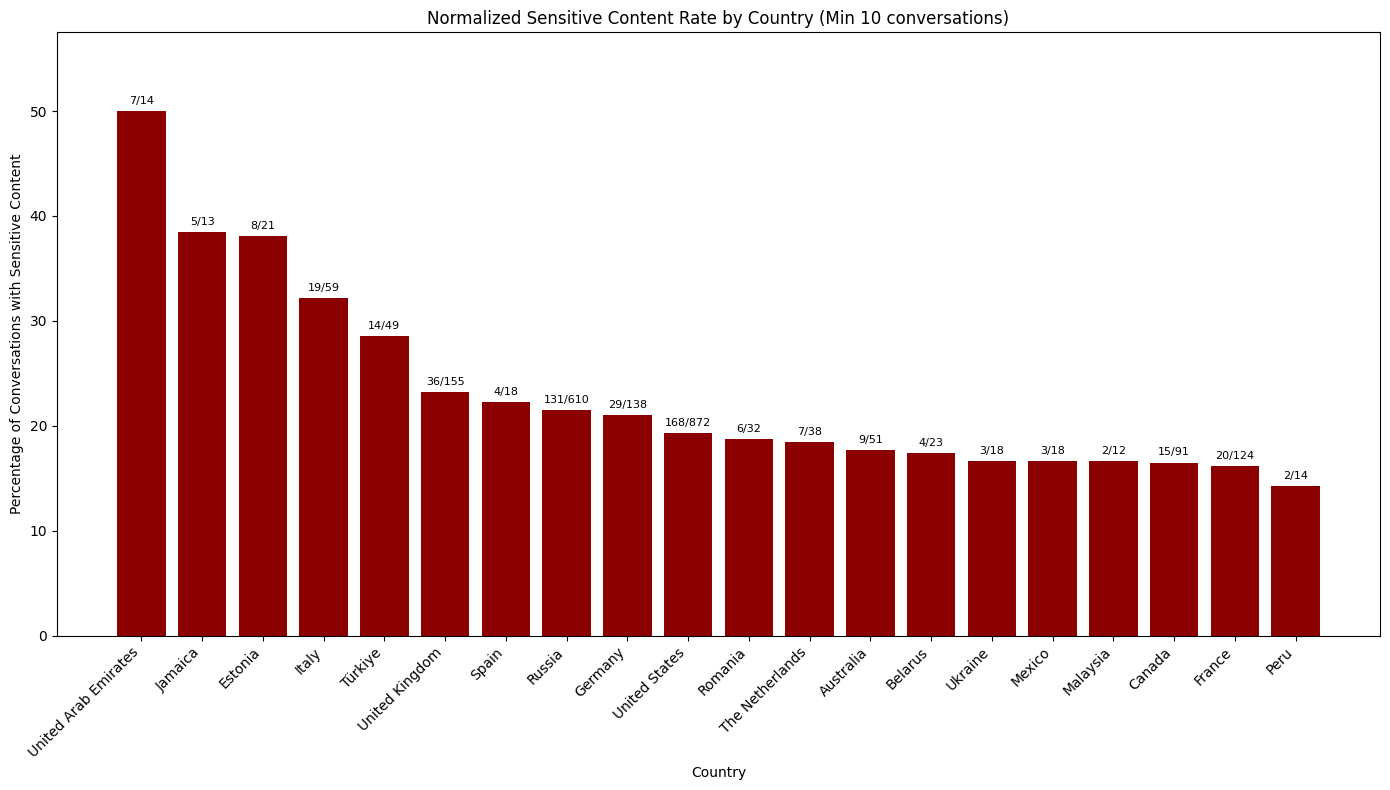

In [17]:
# Calculate total conversations and sensitive conversations by country
country_stats = defaultdict(lambda: {"total": 0, "sensitive": 0})

for conv in dataset.data:
    if conv.geography:
        country = conv.geography.split(';')[0].strip() if ';' in conv.geography else conv.geography
        country_stats[country]["total"] += 1
        
        # Check if conversation has sensitive content
        for msg in conv.conversation:
            if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
                flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
                if isinstance(flag_value, list):
                    if any(flag != "None" for flag in flag_value):
                        country_stats[country]["sensitive"] += 1
                        break
                elif flag_value and flag_value != "None":
                    country_stats[country]["sensitive"] += 1
                    break

# Calculate percentages and filter countries with at least 10 conversations
country_percentages = []
for country, stats in country_stats.items():
    if stats["total"] >= 10:
        percentage = (stats["sensitive"] / stats["total"]) * 100
        country_percentages.append((country, percentage, stats["sensitive"], stats["total"]))

# Sort by percentage
country_percentages.sort(key=lambda x: x[1], reverse=True)

# Create bar chart
countries, percentages, sensitive_counts, total_counts = zip(*country_percentages[:20])

plt.figure(figsize=(14, 8))
bars = plt.bar(countries, percentages, color='darkred')

# Add count labels on bars
for i, (bar, sensitive, total) in enumerate(zip(bars, sensitive_counts, total_counts)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{sensitive}/{total}', ha='center', va='bottom', fontsize=8)

plt.xlabel('Country')
plt.ylabel('Percentage of Conversations with Sensitive Content')
plt.title('Normalized Sensitive Content Rate by Country (Min 10 conversations)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(percentages) * 1.15)  # Add some space for labels
plt.tight_layout()
plt.savefig(f"{outdir}/country_normalized_bar_chart.png")
plt.show()

# RQ 4 4. Temporal Analysis of Sensitive Flags


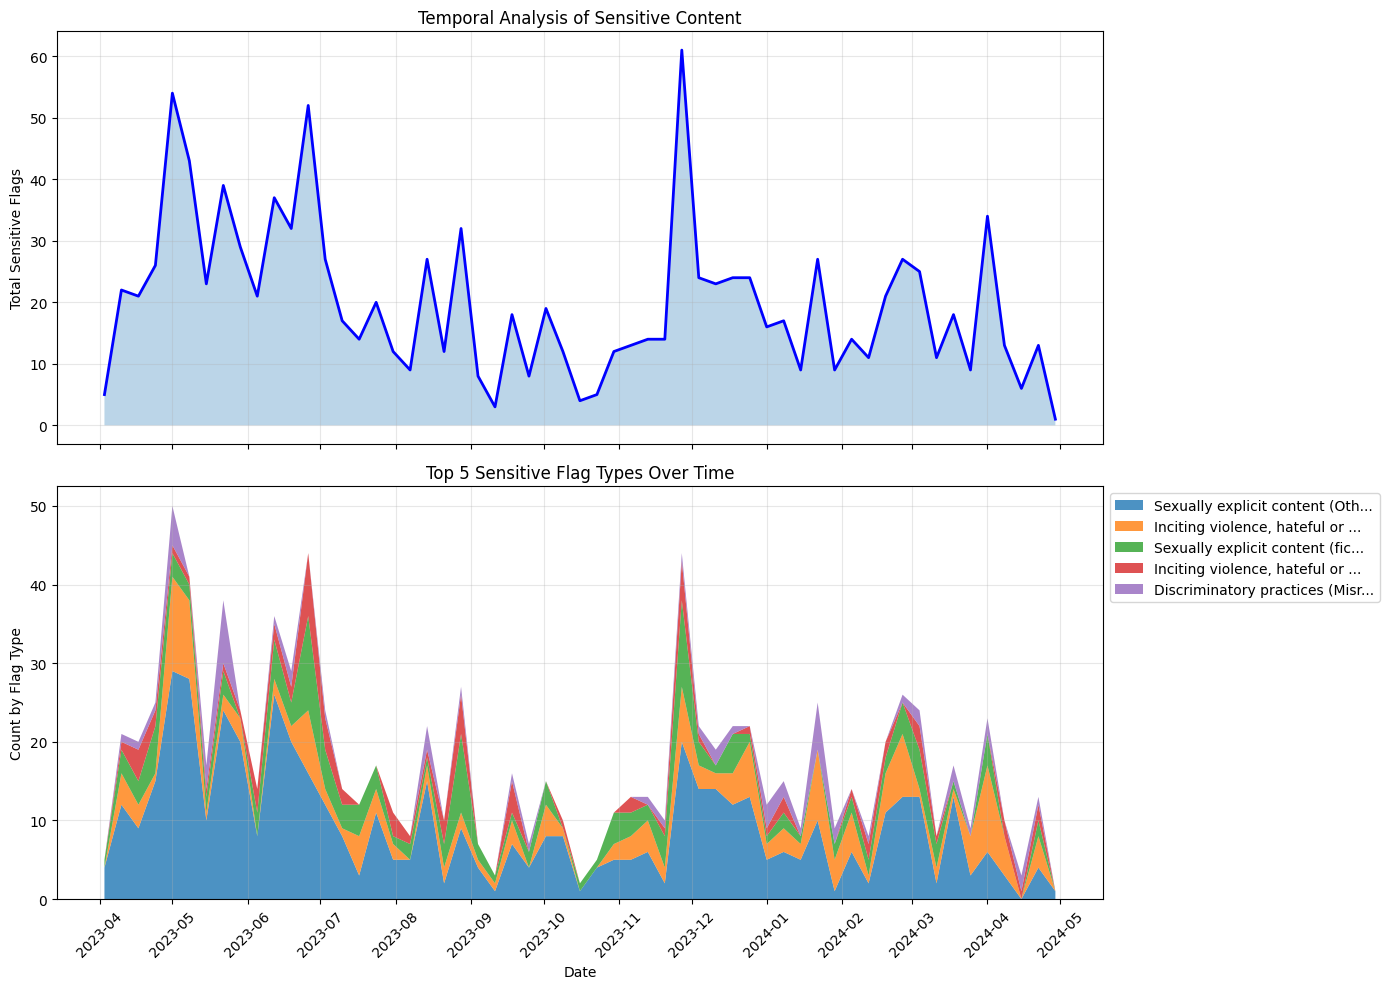

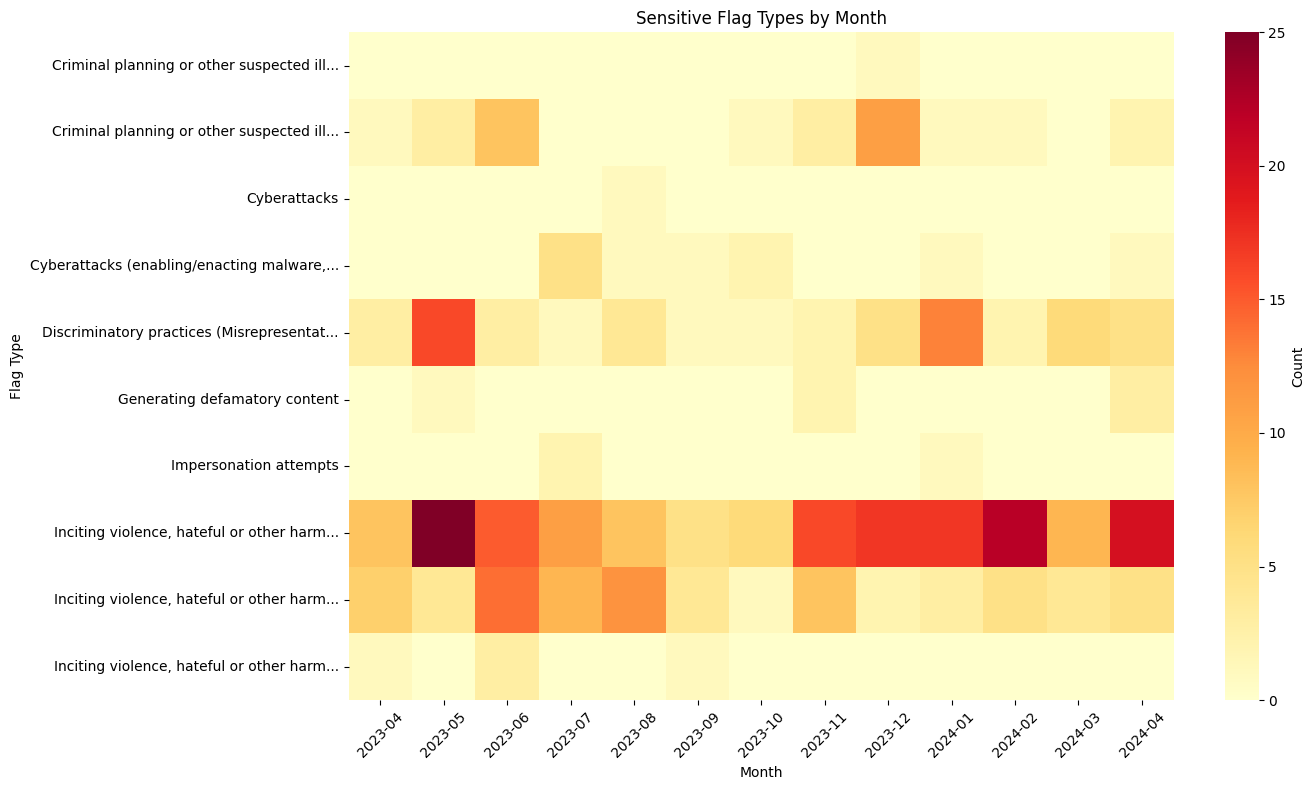

In [19]:
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Collect temporal data with specific flag types
temporal_flag_data = []

for conv in dataset.data:
    if conv.time:
        try:
            time_obj = datetime.fromisoformat(conv.time.replace('Z', '+00:00'))
            
            # Collect all sensitive flags in this conversation
            conv_flags = []
            for msg in conv.conversation:
                if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
                    flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
                    if isinstance(flag_value, list):
                        conv_flags.extend([flag for flag in flag_value if flag != "None"])
                    elif flag_value and flag_value != "None":
                        conv_flags.append(flag_value)
            
            if conv_flags:
                temporal_flag_data.append((time_obj, conv_flags))
        except ValueError:
            continue

# Sort by time
temporal_flag_data.sort(key=lambda x: x[0])

# Group by week and count flag types
weekly_flag_counts = defaultdict(lambda: defaultdict(int))
weekly_totals = defaultdict(int)

for time_obj, flags in temporal_flag_data:
    week_start = time_obj - timedelta(days=time_obj.weekday())
    week_key = week_start.strftime("%Y-%m-%d")
    
    for flag in flags:
        weekly_flag_counts[week_key][flag] += 1
        weekly_totals[week_key] += 1

# Prepare data for stacked area chart
weeks = sorted(weekly_flag_counts.keys())
all_flag_types = set()
for week_flags in weekly_flag_counts.values():
    all_flag_types.update(week_flags.keys())

# Get top 5 most common flag types
flag_totals = defaultdict(int)
for week_flags in weekly_flag_counts.values():
    for flag, count in week_flags.items():
        flag_totals[flag] += count

top_flags = sorted(flag_totals.items(), key=lambda x: x[1], reverse=True)[:5]
top_flag_names = [flag[0] for flag in top_flags]

# Create stacked area chart
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top plot: Total sensitive content over time
week_dates = [datetime.strptime(week, "%Y-%m-%d") for week in weeks]
totals = [weekly_totals[week] for week in weeks]
ax1.plot(week_dates, totals, 'b-', linewidth=2)
ax1.fill_between(week_dates, totals, alpha=0.3)
ax1.set_ylabel('Total Sensitive Flags')
ax1.set_title('Temporal Analysis of Sensitive Content')
ax1.grid(True, alpha=0.3)

# Bottom plot: Stacked area chart of top flag types
flag_data = {flag: [] for flag in top_flag_names}
for week in weeks:
    for flag in top_flag_names:
        flag_data[flag].append(weekly_flag_counts[week].get(flag, 0))

# Create stacked area chart
ax2.stackplot(week_dates, *[flag_data[flag] for flag in top_flag_names], 
              labels=[flag[:30] + "..." if len(flag) > 30 else flag for flag in top_flag_names],
              alpha=0.8)
ax2.set_xlabel('Date')
ax2.set_ylabel('Count by Flag Type')
ax2.set_title('Top 5 Sensitive Flag Types Over Time')
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.grid(True, alpha=0.3)

# Format x-axis
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(f"{outdir}/temporal_analysis_stacked.png", dpi=300, bbox_inches='tight')
plt.show()

# Heatmap of flag types by month
monthly_flag_counts = defaultdict(lambda: defaultdict(int))
for time_obj, flags in temporal_flag_data:
    month_key = time_obj.strftime("%Y-%m")
    for flag in flags:
        monthly_flag_counts[month_key][flag] += 1

# Create matrix for heatmap
months = sorted(monthly_flag_counts.keys())
flag_types = sorted(list(all_flag_types))[:10]  # Top 10 flag types
matrix = []
for flag in flag_types:
    row = [monthly_flag_counts[month].get(flag, 0) for month in months]
    matrix.append(row)

# Create heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(matrix, xticklabels=months, yticklabels=[f[:40]+"..." if len(f) > 40 else f for f in flag_types],
            cmap='YlOrRd', cbar_kws={'label': 'Count'})
plt.title('Sensitive Flag Types by Month')
plt.xlabel('Month')
plt.ylabel('Flag Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{outdir}/temporal_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [25]:
print(flag_types)

['Criminal planning or other suspected illegal activity not listed', 'Criminal planning or other suspected illegal activity not listed elsewhere', 'Cyberattacks', 'Cyberattacks (enabling/enacting malware, computer viruses, worms, malicious code, ...)', 'Discriminatory practices (Misrepresentation, stereotyping, or inappropriate reference to sensitive attributes)', 'Generating defamatory content', 'Impersonation attempts', 'Inciting violence, hateful or other harmful behavior (harassment & bullying)', 'Inciting violence, hateful or other harmful behavior (physical harm)', 'Inciting violence, hateful or other harmful behavior (self-harm)']


# 6. Sensitive Flags Progression Through Turns


Conversations with 4+ turns and sensitive content: 255
Conversations that escalate: 215 (84.3%)


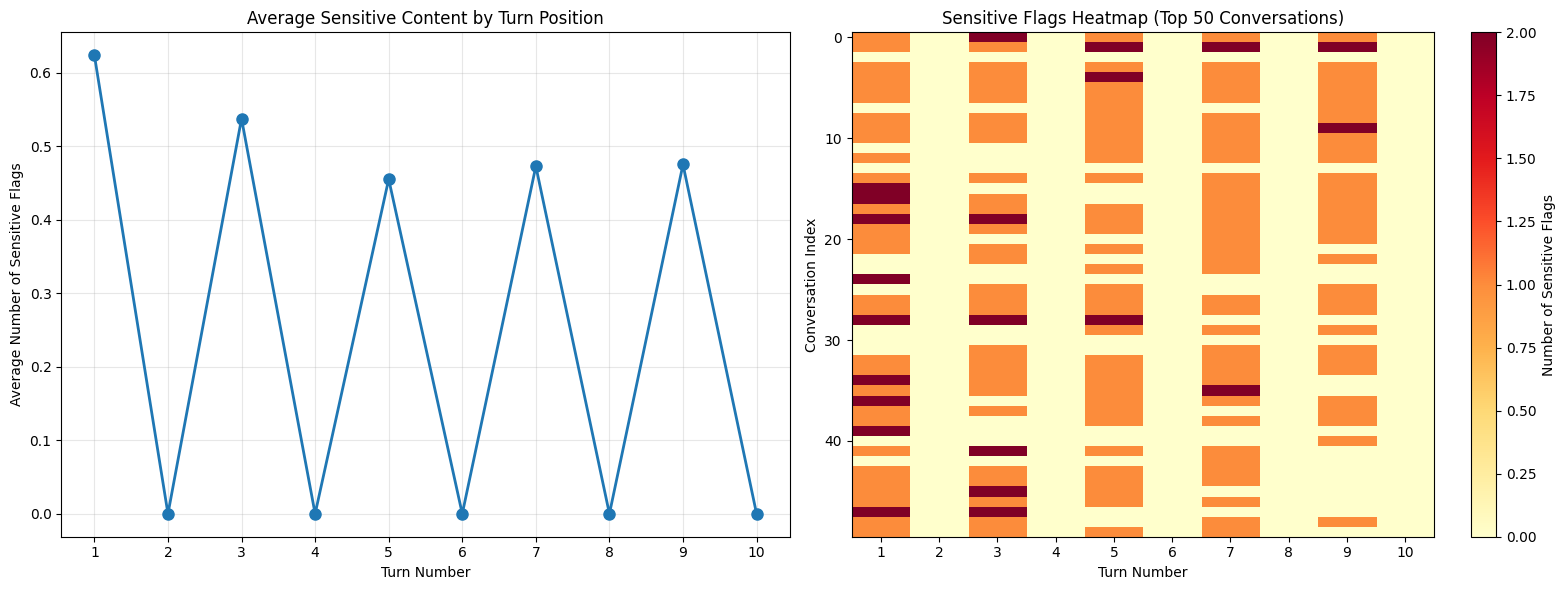


Escalation Analysis:
Early escalation (first half): 178
Late escalation (second half): 37


In [20]:
# Analyze conversations with 4+ turns
turn_progression_data = []

for conv in dataset.data:
    if len(conv.conversation) >= 4:
        # Track sensitive flags by turn
        turn_flags = []
        for msg in conv.conversation:
            if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
                flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
                if isinstance(flag_value, list):
                    non_none_flags = [flag for flag in flag_value if flag != "None"]
                    turn_flags.append(len(non_none_flags))
                else:
                    turn_flags.append(1 if flag_value and flag_value != "None" else 0)
            else:
                turn_flags.append(0)
        
        if any(turn_flags):  # Only include conversations with at least one sensitive flag
            turn_progression_data.append({
                "conv_id": conv.conversation_id,
                "turn_flags": turn_flags,
                "total_flags": sum(turn_flags),
                "escalates": any(turn_flags[i] < turn_flags[i+1] for i in range(len(turn_flags)-1))
            })

# Analyze escalation patterns
escalating_convs = [d for d in turn_progression_data if d["escalates"]]
print(f"Conversations with 4+ turns and sensitive content: {len(turn_progression_data)}")
print(f"Conversations that escalate: {len(escalating_convs)} ({len(escalating_convs)/len(turn_progression_data)*100:.1f}%)")

# Create visualization for turn progression
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Average sensitive flags by turn position
max_turns = 10  # Analyze up to 10 turns
turn_averages = []
for turn_idx in range(max_turns):
    flags_at_turn = []
    for data in turn_progression_data:
        if turn_idx < len(data["turn_flags"]):
            flags_at_turn.append(data["turn_flags"][turn_idx])
    if flags_at_turn:
        turn_averages.append(np.mean(flags_at_turn))
    else:
        turn_averages.append(0)

ax1.plot(range(1, max_turns+1), turn_averages, 'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Turn Number')
ax1.set_ylabel('Average Number of Sensitive Flags')
ax1.set_title('Average Sensitive Content by Turn Position')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, max_turns+1))

# Right plot: Heatmap of individual conversations
# Sample up to 50 conversations for visibility
sample_size = min(50, len(turn_progression_data))
sampled_data = sorted(turn_progression_data, key=lambda x: x["total_flags"], reverse=True)[:sample_size]

# Create matrix for heatmap
matrix = []
for data in sampled_data:
    row = data["turn_flags"][:max_turns]
    # Pad with zeros if needed
    row.extend([0] * (max_turns - len(row)))
    matrix.append(row)

im = ax2.imshow(matrix, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax2.set_xlabel('Turn Number')
ax2.set_ylabel('Conversation Index')
ax2.set_title(f'Sensitive Flags Heatmap (Top {sample_size} Conversations)')
ax2.set_xticks(range(max_turns))
ax2.set_xticklabels(range(1, max_turns+1))

# Add colorbar
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Number of Sensitive Flags')

plt.tight_layout()
plt.savefig(f"{outdir}/turn_progression_analysis.png", dpi=300)
plt.show()

# Analyze specific escalation patterns
print("\nEscalation Analysis:")
early_escalation = 0
late_escalation = 0
for data in escalating_convs:
    flags = data["turn_flags"]
    for i in range(len(flags)-1):
        if flags[i] < flags[i+1]:
            if i < len(flags) // 2:
                early_escalation += 1
            else:
                late_escalation += 1
            break

print(f"Early escalation (first half): {early_escalation}")
print(f"Late escalation (second half): {late_escalation}")

Analysis 1: Co-occurrence of Sensitive Flag Types


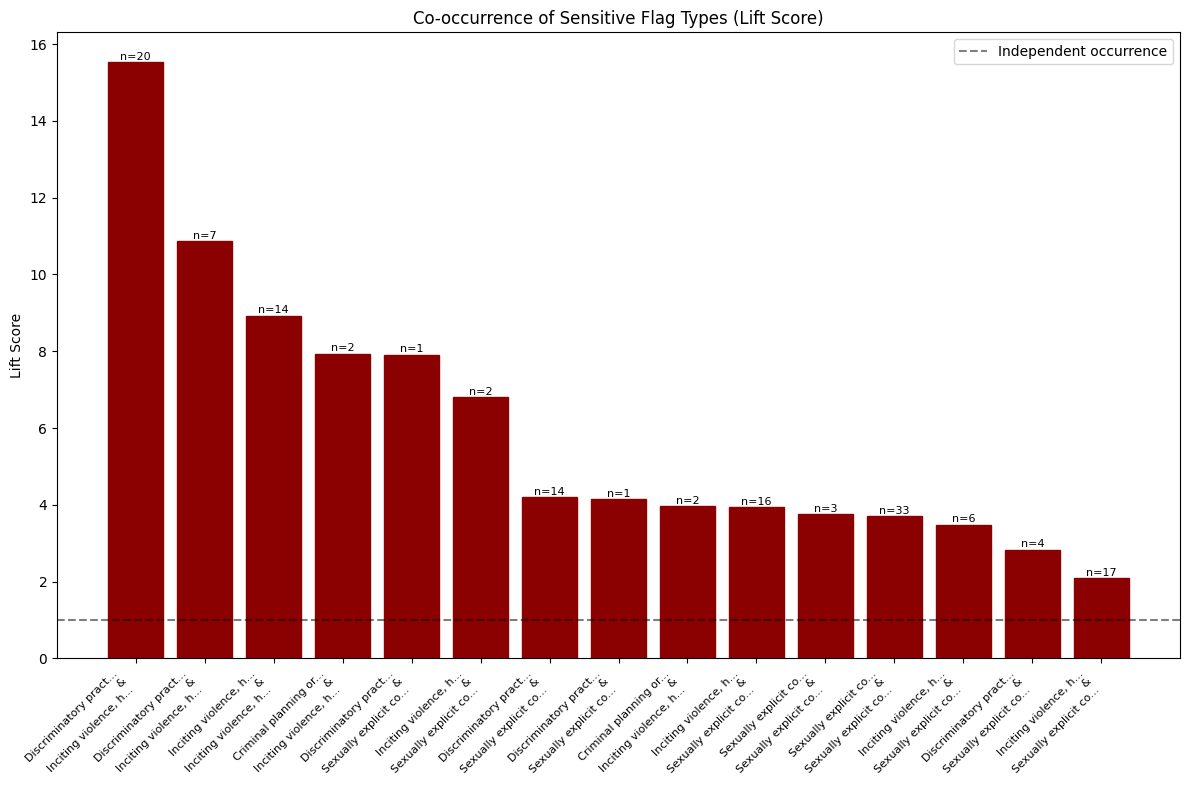

In [21]:
# Analyze which sensitive flags tend to appear together
from itertools import combinations

flag_cooccurrence = defaultdict(int)
individual_flag_counts = defaultdict(int)

for conv in dataset.data:
    conv_flags = set()
    for msg in conv.conversation:
        if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
            flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
            if isinstance(flag_value, list):
                conv_flags.update([flag for flag in flag_value if flag != "None"])
            elif flag_value and flag_value != "None":
                conv_flags.add(flag_value)
    
    # Count individual flags
    for flag in conv_flags:
        individual_flag_counts[flag] += 1
    
    # Count co-occurrences
    if len(conv_flags) >= 2:
        for flag1, flag2 in combinations(sorted(conv_flags), 2):
            flag_cooccurrence[(flag1, flag2)] += 1

# Calculate lift scores (how much more likely flags appear together than separately)
lift_scores = []
for (flag1, flag2), count in flag_cooccurrence.items():
    if individual_flag_counts[flag1] > 10 and individual_flag_counts[flag2] > 10:
        expected = (individual_flag_counts[flag1] * individual_flag_counts[flag2]) / len(dataset.data)
        lift = count / expected if expected > 0 else 0
        lift_scores.append(((flag1, flag2), lift, count))

# Sort by lift score
lift_scores.sort(key=lambda x: x[1], reverse=True)

# Visualize top co-occurrences
top_pairs = lift_scores[:15]
if top_pairs:
    pair_labels = [f"{p[0][0][:20]}...\n&\n{p[0][1][:20]}..." for p in top_pairs]
    lift_values = [p[1] for p in top_pairs]
    counts = [p[2] for p in top_pairs]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.bar(range(len(pair_labels)), lift_values)
    
    # Color bars based on lift value
    for i, bar in enumerate(bars):
        if lift_values[i] > 2:
            bar.set_color('darkred')
        elif lift_values[i] > 1.5:
            bar.set_color('orange')
        else:
            bar.set_color('gray')
    
    # Add count labels
    for i, (bar, count) in enumerate(zip(bars, counts)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'n={count}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xticks(range(len(pair_labels)))
    ax.set_xticklabels(pair_labels, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Lift Score')
    ax.set_title('Co-occurrence of Sensitive Flag Types (Lift Score)')
    ax.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Independent occurrence')
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"{outdir}/flag_cooccurrence.png", dpi=300, bbox_inches='tight')
    plt.show()

Analysis 2: Conversation Length vs Sensitive Content


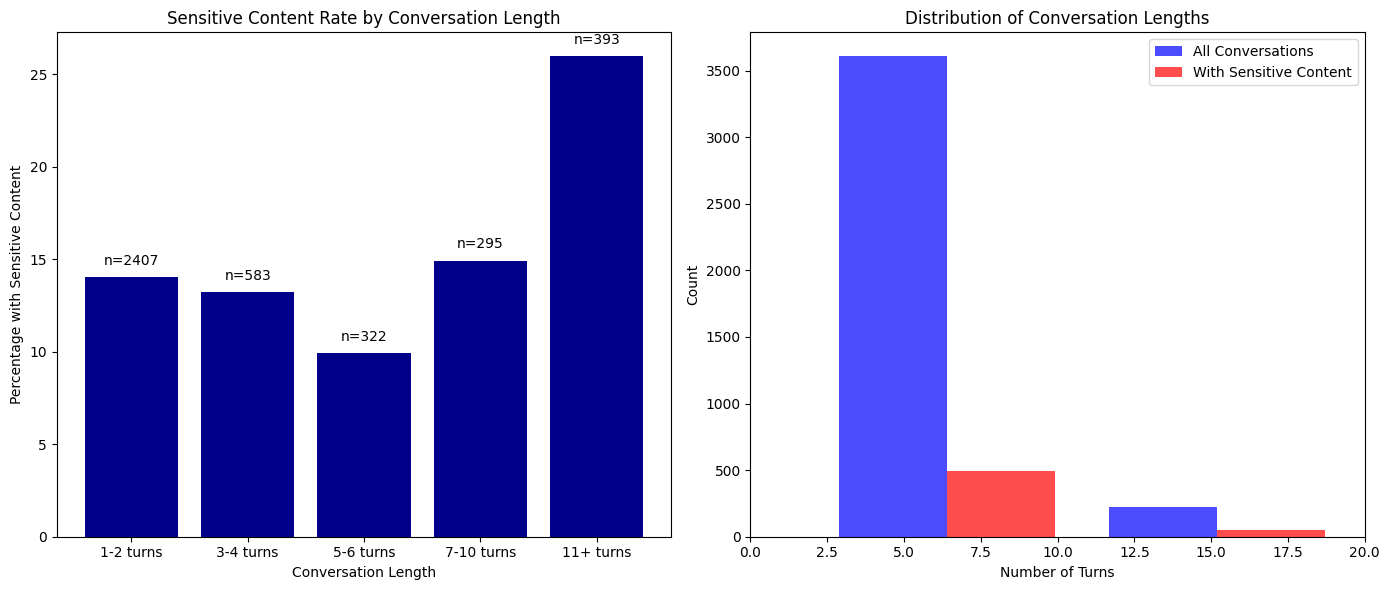

In [22]:
# Analyze relationship between conversation length and sensitive content
length_bins = {
    "1-2 turns": {"range": (1, 2), "sensitive": 0, "total": 0},
    "3-4 turns": {"range": (3, 4), "sensitive": 0, "total": 0},
    "5-6 turns": {"range": (5, 6), "sensitive": 0, "total": 0},
    "7-10 turns": {"range": (7, 10), "sensitive": 0, "total": 0},
    "11+ turns": {"range": (11, float('inf')), "sensitive": 0, "total": 0}
}

for conv in dataset.data:
    conv_length = len(conv.conversation)
    has_sensitive = False
    
    # Check if conversation has sensitive content
    for msg in conv.conversation:
        if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
            flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
            if isinstance(flag_value, list):
                if any(flag != "None" for flag in flag_value):
                    has_sensitive = True
                    break
            elif flag_value and flag_value != "None":
                has_sensitive = True
                break
    
    # Categorize by length
    for bin_name, bin_info in length_bins.items():
        if bin_info["range"][0] <= conv_length <= bin_info["range"][1]:
            bin_info["total"] += 1
            if has_sensitive:
                bin_info["sensitive"] += 1
            break

# Calculate percentages and create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Percentage with sensitive content by length
bin_names = list(length_bins.keys())
percentages = []
totals = []
for bin_name in bin_names:
    total = length_bins[bin_name]["total"]
    sensitive = length_bins[bin_name]["sensitive"]
    percentage = (sensitive / total * 100) if total > 0 else 0
    percentages.append(percentage)
    totals.append(total)

bars1 = ax1.bar(bin_names, percentages, color='darkblue')
ax1.set_xlabel('Conversation Length')
ax1.set_ylabel('Percentage with Sensitive Content')
ax1.set_title('Sensitive Content Rate by Conversation Length')

# Add count labels
for bar, total, percentage in zip(bars1, totals, percentages):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'n={total}', ha='center', va='bottom', fontsize=10)

# Right plot: Distribution of conversation lengths
all_lengths = [len(conv.conversation) for conv in dataset.data]
sensitive_lengths = []
for conv in dataset.data:
    has_sensitive = False
    for msg in conv.conversation:
        if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
            flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
            if isinstance(flag_value, list):
                if any(flag != "None" for flag in flag_value):
                    has_sensitive = True
                    break
            elif flag_value and flag_value != "None":
                has_sensitive = True
                break
    if has_sensitive:
        sensitive_lengths.append(len(conv.conversation))

ax2.hist([all_lengths, sensitive_lengths], bins=20, label=['All Conversations', 'With Sensitive Content'],
         alpha=0.7, color=['blue', 'red'])
ax2.set_xlabel('Number of Turns')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Conversation Lengths')
ax2.legend()
ax2.set_xlim(0, 20)

plt.tight_layout()
plt.savefig(f"{outdir}/length_vs_sensitive.png", dpi=300)
plt.show()